In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
import numpy as np
import pandas as pd

In [170]:
file_path = '/content/drive/My Drive/New Neural Networks innlevering 1/SpotifyFeatures.csv'

In [172]:
full_dataset = pd.read_csv(file_path)

In [149]:
print(f"Number of samples (songs): {full_dataset.shape[0]}")
print(f"Number of features (song properties): {full_dataset.shape[1]}")

Full dataset - Number of samples (songs): 232725
Full dataset - Number of features (song properties): 18


In [173]:
# Load the data from the csv file into a Pandas DataFrame object while taking only the features we are looking at, and the genre as label
dataset = pd.read_csv(file_path, usecols=['liveness', 'loudness', 'genre'])

# Filter for 'Pop' and 'Classical' genres/labels
dataset = dataset[dataset['genre'].isin(['Pop', 'Classical'])]

# Designate our classes as integers
dataset.loc[dataset['genre'] == 'Pop', 'genre'] = 1
dataset.loc[dataset['genre'] == 'Classical', 'genre'] = 0

# Report the number of samples in each label
print("\nNumber of samples in each label:")
print(dataset['genre'].value_counts())


Number of samples in each class:
genre
1    9386
0    9256
Name: count, dtype: int64


In [151]:
# Initialize empty train and test dataset to fill
train_dataset = []
test_dataset = []

# Hyperparameters
train_size = 0.8  # Percentage of dataset that will go to training, approximately

# Splits our dataset between training and testing. Isn't exact, but with the number in the thousands, it is close, and is an easy way of ensuring both datasets are diversified with the two genres. If we were to sort randomly through we could probably improve the performance even more by ensuring clumps of same genre doesn't bias the model too much towards just labeling all as that genre rather than generalizing
for i in range(len(dataset)):
    if np.random.random() <= train_size:
        train_dataset.append([dataset['liveness'].iloc[i], dataset['loudness'].iloc[i], dataset['genre'].iloc[i]])
    else:
        test_dataset.append([dataset['liveness'].iloc[i], dataset['loudness'].iloc[i], dataset['genre'].iloc[i]])

# Convert to numpy arrays
train_dataset = np.array(train_dataset)
test_dataset = np.array(test_dataset)

# Separate features and labels
X_train, y_train = train_dataset[:, :-1], train_dataset[:, -1]
X_test, y_test = test_dataset[:, :-1], test_dataset[:, -1]

In [152]:
# Print some information about the split
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Verify class distribution in training and test sets
print("\nClass distribution in training set:")
print(np.unique(y_train, return_counts=True))
print("\nClass distribution in test set:")
print(np.unique(y_test, return_counts=True))

Total samples: 18642
Training samples: 15015
Test samples: 3627

Class distribution in training set:
(array([0., 1.]), array([7475, 7540]))

Class distribution in test set:
(array([0., 1.]), array([1781, 1846]))


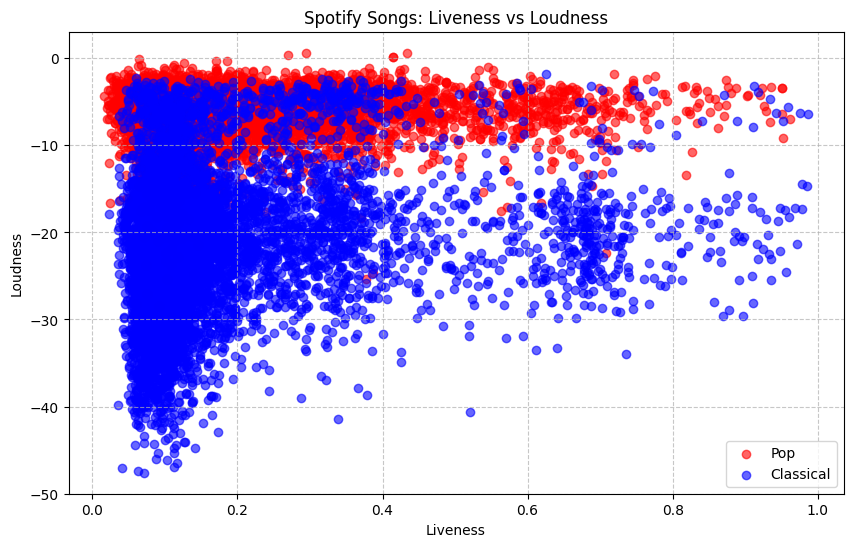

Pop music averages:
Liveness: 0.1800
Loudness: -6.4954

Classical music averages:
Liveness: 0.1628
Loudness: -21.5445


In [153]:
import matplotlib.pyplot as plt

# Separate the data by class
pop_data = dataset[dataset['genre'] == 1]
classical_data = dataset[dataset['genre'] == 0]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pop_data['liveness'], pop_data['loudness'], color='red', label='Pop', alpha=0.6)
plt.scatter(classical_data['liveness'], classical_data['loudness'], color='blue', label='Classical', alpha=0.6)

plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Spotify Songs: Liveness vs Loudness')
plt.legend()

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Calculate and print the means for each class
print("Pop music averages:")
print(f"Liveness: {pop_data['liveness'].mean():.4f}")
print(f"Loudness: {pop_data['loudness'].mean():.4f}")

print("\nClassical music averages:")
print(f"Liveness: {classical_data['liveness'].mean():.4f}")
print(f"Loudness: {classical_data['loudness'].mean():.4f}")

In [154]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, num_epochs=60):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        errors = []

        for epoch in range(self.num_epochs):
            for idx in range(num_samples):
                linear_pred = np.dot(X[idx], self.weights) + self.bias
                pred = self.sigmoid(linear_pred)

                # Compute gradients
                dw = (pred - y[idx]) * X[idx]
                db = pred - y[idx]

                # Update parameters
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Compute error for the entire epoch
            y_pred = self.predict(X)
            error = np.mean((y_pred - y)**2)
            errors.append(error)

        return errors

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_pred)

Accuracy (LR=1e-05): 0.9006
Accuracy (LR=0.0001): 0.9209
Accuracy (LR=0.001): 0.8884
Accuracy (LR=0.01): 0.5844
Accuracy (LR=0.1): 0.5034


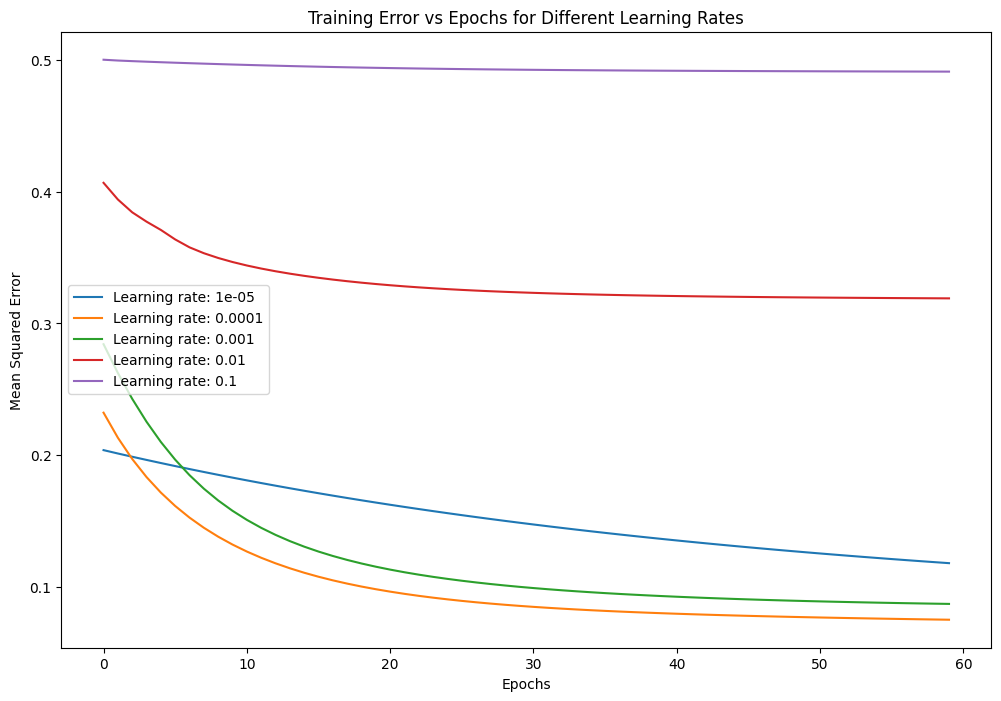

In [174]:
# Different learning rates or "jumps" to see which leads to the better outcome. Jumping too far prevents entering and honing in on any optima, too small traps one in a often very sub-optimal local optima. Best is starting higher and gradually decreasing step size, to localize closer to global optimas, and then manage to descend without overstepping out
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

plt.figure(figsize=(12, 8))

# Trains the model and attempts to predict for each learning rate to see which does better
for lr in learning_rates:
    model = LogisticRegression(learning_rate=lr, num_epochs=60)
    errors = model.train(X_train, y_train)

    plt.plot(range(len(errors)), errors, label=f'Learning rate: {lr}')

    # Compute and print accuracy
    y_pred = model.predict(X_train)
    accuracy = np.mean(y_pred.round() == y_train)
    print(f"Accuracy (LR={lr}): {accuracy:.4f}")

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Error vs Epochs for Different Learning Rates')
plt.legend()
plt.show()

In [159]:
# Second part: Comparing performance on training and test sets
learning_rate = 0.0001  # Choose the best learning rate from the previous step
num_epochs = 60
model = LogisticRegression(learning_rate=learning_rate, num_epochs=num_epochs)

# Train the model once
errors = model.train(X_train, y_train)

# Evaluate on both training and test sets
for name, X, y in [("Training", X_train, y_train), ("Test", X_test, y_test)]:
    y_pred = model.predict(X)
    accuracy = np.mean(y_pred.round() == y)
    print(f"{name} Accuracy (LR={learning_rate}): {accuracy:.4f}")

Training Accuracy (LR=0.0001): 0.9209
Test Accuracy (LR=0.0001): 0.9090


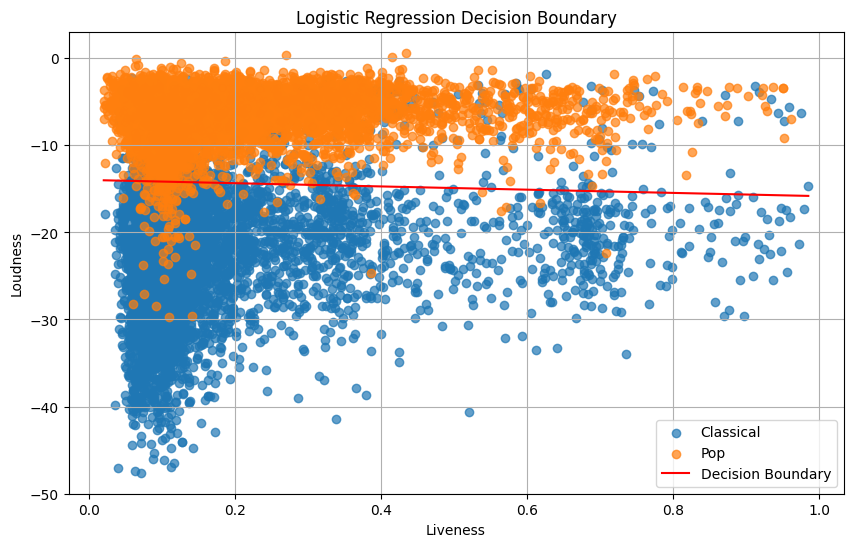

Decision Boundary Equation: y = -1.8588x + -13.9776


In [160]:
weights = model.weights
bias = model.bias

# Create a scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Classical', alpha=0.7)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Pop', alpha=0.7)

# Calculate the decision boundary
x1 = np.array([min(X_train[:, 0]), max(X_train[:, 0])])
m = -weights[0] / weights[1]
b = -bias / weights[1]
x2 = m * x1 + b

# Plot the decision boundary
plt.plot(x1, x2, 'r-', label='Decision Boundary')

plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

# Print the equation of the decision boundary
print(f"Decision Boundary Equation: y = {m:.4f}x + {b:.4f}")

In [169]:
# After training and evaluating the model

# Make predictions on the test set
y_test_pred = model.predict(X_test)
y_test_pred_label = (y_test_pred > 0.5).astype(int)

# Initialize confusion matrix values
TP = 0  # True Positives: Pop correctly classified as Pop
TN = 0  # True Negatives: Classical correctly classified as Classical
FP = 0  # False Positives: Classical incorrectly classified as Pop
FN = 0  # False Negatives: Pop incorrectly classified as Classical

# Loop through test set and compute TP, TN, FP, FN
for i in range(len(y_test)):
    if y_test[i] == 1 and y_test_pred_label[i] == 1:
        TP += 1  # True Positive
    elif y_test[i] == 0 and y_test_pred_label[i] == 0:
        TN += 1  # True Negative
    elif y_test[i] == 0 and y_test_pred_label[i] == 1:
        FP += 1  # False Positive
    elif y_test[i] == 1 and y_test_pred_label[i] == 0:
        FN += 1  # False Negative

# Display the confusion matrix
print("\nConfusion Matrix:")
print(f"TP (Pop correctly classified as Pop): {TP}")
print(f"TN (Classical correctly classified as Classical): {TN}")
print(f"FP (Classical incorrectly classified as Pop): {FP}")
print(f"FN (Pop incorrectly classified as Classical): {FN}")

# Calculate and display additional metrics
total = TP + TN + FP + FN
accuracy = (TP + TN) / total
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Display as a 2x2 matrix as we have only two labels
print("\nConfusion Matrix as 2x2:")
print(f"                           Predicted Classical  Predicted Pop")
print(f"Actual Classical  {TN:17d} {FP:15d}")
print(f"Actual Pop        {FN:17d} {TP:15d}")


Confusion Matrix:
TP (Pop correctly classified as Pop): 1814
TN (Classical correctly classified as Classical): 1483
FP (Classical incorrectly classified as Pop): 298
FN (Pop incorrectly classified as Classical): 32

Accuracy: 0.9090
Precision: 0.8589
Recall: 0.9827
F1 Score: 0.9166

Confusion Matrix as 2x2:
                           Predicted Classical  Predicted Pop
Actual Classical               1483             298
Actual Pop                       32            1814
